In [28]:
# Enable IPython autoreload for modules
%load_ext autoreload
%autoreload 2

import pandas as pd 
# Load configuration
data_dir = None # To silence Pylance; data_dir is defined by the config.py file.
%run ../../../config.py

from lib import download_ookla_files, get_ookla_data, list_ookla_objects, build_files_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/max/proj/WirelessIncome
Data directory: /Users/max/proj/WirelessIncome/data


In [29]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import os
from urllib.parse import urlparse

# Create S3 client with no signing (for public buckets)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# List parquet URIs from Ookla bucket
parquet_files = list_ookla_objects(s3)

# Build dataset of file paths with metadata
files_df = build_files_df(parquet_files)

files_df.head(20)

,path,service_type,year,quarter
0,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,1
1,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,2
2,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,3
3,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,4
4,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,1
5,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,2
6,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,3
7,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,4
8,s3://ookla-open-data/parquet/performance/type=...,fixed,2021,1
9,s3://ookla-open-data/parquet/performance/type=...,fixed,2021,2


In [30]:
files_df.year.value_counts()

year
2019    8
2020    8
2021    8
2022    8
2023    8
2024    8
2025    6
Name: count, dtype: int64

In [31]:
# Download mobile parquet files for Q1 2019
mobile_2019 = download_ookla_files(
    files_df,
    years=2019,
    quarters=[1],
    service_type='mobile',
    data_dir=data_dir,
    s3=s3
)

print(f"Returned rows: {len(mobile_2019)}")
mobile_2019.head()

Found 1 mobile files for years=[2019], quarters=[1]
2019-01-01_performance_mobile_tiles.parquet already exists, skipping

Downloaded 1 files
Returned rows: 1


,path,service_type,year,quarter,local_path
27,s3://ookla-open-data/parquet/performance/type=...,mobile,2019,1,/Users/max/proj/WirelessIncome/data/2019-01-01...


In [32]:
# Example usage: load mobile data for 2019 Q1
df = get_ookla_data(files_df, year=2019, quarter=1, service_type='mobile', data_dir=data_dir)



Loading 2019-01-01_performance_mobile_tiles.parquet...
  Loaded 3231245 rows
Concatenated 1 files -> 3231245 total rows
  Loaded 3231245 rows
Concatenated 1 files -> 3231245 total rows


In [33]:
df.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type
0,0022133222330121,"POLYGON((-160.021362304688 70.6381267305321, -...",5983,7886,68,1,1,2019,1,mobile
1,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",3748,5841,78,21,2,2019,1,mobile
2,0022133222330203,"POLYGON((-160.043334960938 70.6326624870732, -...",3364,6200,78,10,2,2019,1,mobile
3,0022133222330210,"POLYGON((-160.037841796875 70.6344840663086, -...",2381,2328,86,2,1,2019,1,mobile
4,0022133222330212,"POLYGON((-160.037841796875 70.6326624870732, -...",3047,5356,75,1,1,2019,1,mobile


In [34]:
df.columns

Index(['quadkey', 'tile', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests',
       'devices', 'ookla_year', 'ookla_quarter', 'ookla_service_type'],
      dtype='object')

In [35]:
import geopandas as gpd
from shapely import wkt

# Build centroids from tile WKT polygons to represent each tile
tile_polygons = gpd.GeoSeries(df['tile'].apply(wkt.loads), crs='EPSG:4326')
centroids = tile_polygons.to_crs(epsg=3857).centroid.to_crs(epsg=4326)

gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=centroids,
    crs='EPSG:4326'  # WGS84 lat/lon
)

print(f"Created GeoDataFrame with {len(gdf)} centroids")
gdf.head()

Created GeoDataFrame with 3231245 centroids


,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry
0,0022133222330121,"POLYGON((-160.021362304688 70.6381267305321, -...",5983,7886,68,1,1,2019,1,mobile,POINT (-160.01862 70.63722)
1,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",3748,5841,78,21,2,2019,1,mobile,POINT (-160.04059 70.63357)
2,0022133222330203,"POLYGON((-160.043334960938 70.6326624870732, -...",3364,6200,78,10,2,2019,1,mobile,POINT (-160.04059 70.63175)
3,0022133222330210,"POLYGON((-160.037841796875 70.6344840663086, -...",2381,2328,86,2,1,2019,1,mobile,POINT (-160.0351 70.63357)
4,0022133222330212,"POLYGON((-160.037841796875 70.6326624870732, -...",3047,5356,75,1,1,2019,1,mobile,POINT (-160.0351 70.63175)


In [37]:
# Sample and filter the data
t = gdf

t = t[t['quadkey'].str.startswith('0')]

# Drop coordinate and quadkey columns
uss_df = t.drop(columns=['quadkey', 'tile'])
uss_df.head()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry
0,5983,7886,68,1,1,2019,1,mobile,POINT (-160.01862 70.63722)
1,3748,5841,78,21,2,2019,1,mobile,POINT (-160.04059 70.63357)
2,3364,6200,78,10,2,2019,1,mobile,POINT (-160.04059 70.63175)
3,2381,2328,86,2,1,2019,1,mobile,POINT (-160.0351 70.63357)
4,3047,5356,75,1,1,2019,1,mobile,POINT (-160.0351 70.63175)


<Axes: >

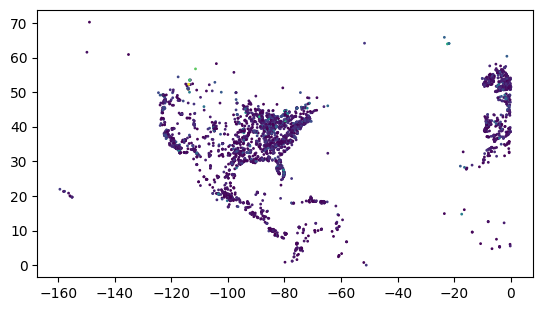

In [38]:
uss_df.sample(4000).plot(markersize=1, column="avg_d_kbps")


In [39]:
uss_df[uss_df.avg_d_kbps > 10000].sample(4000).avg_d_kbps.describe()

count      4000.000000
mean      41426.912250
std       32164.069183
min       10009.000000
25%       19863.750000
50%       31826.500000
75%       51857.000000
max      311609.000000
Name: avg_d_kbps, dtype: float64

In [40]:
# Save to parquet file
import os
output_path = os.path.join(data_dir, 'uss_mobile_2019q1.parquet')
uss_df.to_parquet(output_path)
print(f"Saved {len(uss_df)} rows to {output_path}")

Saved 783624 rows to /Users/max/proj/WirelessIncome/data/uss_mobile_2019q1.parquet


<Axes: >

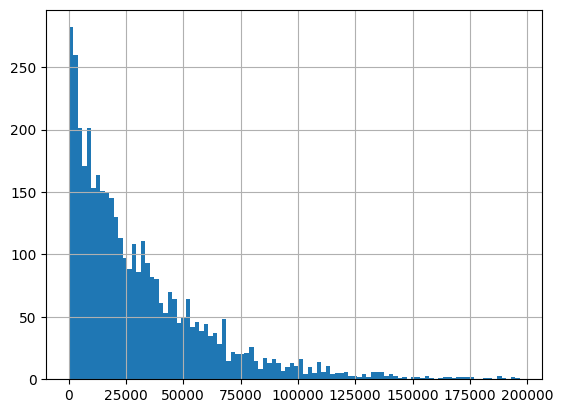

In [41]:
uss_df.avg_d_kbps[uss_df.avg_d_kbps < .2e6].sample(4000).hist(bins=100)